<a href="https://colab.research.google.com/github/aviadm24/aviad2/blob/master/StamLetters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
import os
import cv2 as cv
from google.colab.patches import cv2_imshow

In [ ]:
import h5py

In [ ]:
print(tf.__version__)

2.7.0


In [ ]:
import pathlib
# ImageFolder = "/content/drive/My Drive/stam/all_letters"
ImageFolder = "/content/drive/My Drive/train"
#dataset_url = "https://drive.google.com/folderview?id=1i5SXJsNbIQn7H8jgYqxB-Br3CUl5DlpC"
#data_dir = tf.keras.utils.get_file(origin=ImageFolder,
#                                   fname='letter_photos',
#                                   untar=False)
data_dir = pathlib.Path(ImageFolder)

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2922


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2922 files belonging to 33 classes.
Using 2338 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2922 files belonging to 33 classes.
Using 584 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))

['ain', 'aleph', 'beth', 'caf', 'caf_sofit', 'chin', 'daleth', 'guimel', 'he', 'heth', 'kouf', 'kouf coupe', 'lamed', 'mem', 'mem_sofit', 'mixed', 'noun', 'noun_sofit', 'pe', 'pe_sofit', 'rech', 'sameh', 'tav', 'teth', 'tsadik', 'tsadik_sofit', 'unknown', 'vav', 'vavyoud', 'youd', 'zain', 'zevel', 'zevel2']
33


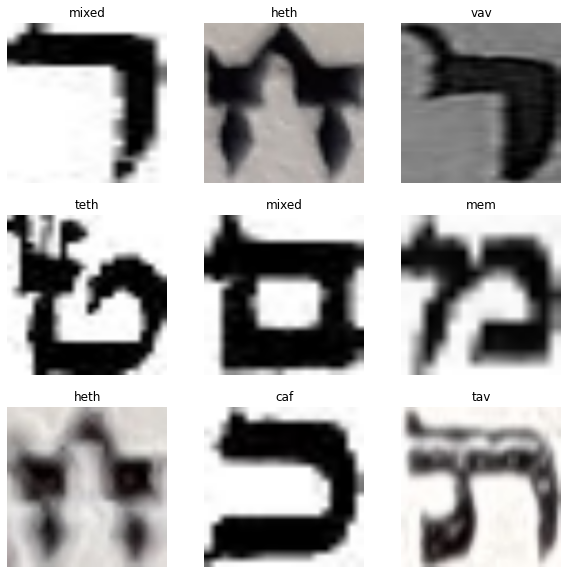

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00024010395 0.84145975


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = 33

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
74/74 [==============================] - 272s 4s/step - loss: 1.9981 - accuracy: 0.5064 - val_loss: 1.0398 - val_accuracy: 0.7825
Epoch 2/3
74/74 [==============================] - 4s 48ms/step - loss: 0.6966 - accuracy: 0.8289 - val_loss: 0.7855 - val_accuracy: 0.8271
Epoch 3/3
74/74 [==============================] - 3s 46ms/step - loss: 0.4386 - accuracy: 0.8837 - val_loss: 0.7292 - val_accuracy: 0.8202


In [ ]:

saveModelPath = "/content/drive/My Drive/stam/stam.h5"

In [ ]:
model.save(saveModelPath)

In [ ]:
Dir = "/content/drive/MyDrive/stam/"
NadamFileModelPath= Dir+"/output/Nadam_beta_1_256_30.hdf5"
stam_model = Dir+"stam.h5"

In [ ]:
#for file in os.listdir(Dir):
#    print(file, " - ")
#    f = h5py.File(NadamFileModelPath, 'r')
#    for atrr in f.attrs:
#        print(atrr)
f = h5py.File(Dir+"stam.h5", 'r')
print(f.__dict__)
for atrr in f.attrs:
    print(atrr)

{'_libver': (None, 'latest'), '_id': <h5py.h5f.FileID object at 0x7fcbcb842cb0>}
backend
keras_version
model_config
training_config


In [ ]:
reconstructed_model = tf.keras.models.load_model(stam_model)

In [ ]:
ImageForPrediction = "/content/drive/My Drive/stam/zain.png"
img = cv.imread(ImageForPrediction)
img = cv.resize(img,(180,180))
img = np.reshape(img,[1,180,180,3])

predicted = reconstructed_model.predict(img)
predicted_class = np.argmax(predicted)
print(predicted_class)
print(class_names[predicted_class])

17
noun_sofit


In [ ]:
def resize(file):
    img = cv.imread(file)
    print('Original Dimensions : ', img.shape)
    scale_percent = 850/img.shape[0]
    width = int(img.shape[1] * scale_percent)
    height = int(img.shape[0] * scale_percent)
    dim = (width, height)
    resized = cv.resize(img, dim, interpolation=cv.INTER_AREA)
    print('reaized : ', resized.shape)
    # cv2_imshow(resized)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

    return resized

In [ ]:

def show_rects(file):
    imageRects = []
    # frame = cv2.imread(file)
    # print(frame.shape)
    frame = resize(file)
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    lower_black = np.array([-20, -20, -50])
    upper_black = np.array([190, 280, 90])
    # Threshold the HSV image to get only black colors
    mask = cv.inRange(hsv, lower_black, upper_black)
    res = cv.bitwise_and(frame, frame, mask=mask)
    kernel = np.ones((3, 3), np.uint8)
    erosion = cv.erode(mask, kernel, iterations=1)
    #cv2.imshow("erosion", erosion)
    #cv2.waitKey(0)
    # dilation = cv2.dilate(mask, kernel, iterations=1)
    # cv2.imshow("dilation", dilation)
    # cv2.waitKey(0)
    cv2_imshow(frame)
    cv2_imshow(mask)
    cv2_imshow(erosion)
    #cv2.imshow('mask', mask)
    #cv2.imshow('res', res)
    contours, hierarchy = cv.findContours(erosion.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    print('len: ', len(contours))
    mask = np.zeros(frame.shape, dtype=np.uint8)

    for num, idx in enumerate(range(len(contours))):
        x, y, w, h = cv.boundingRect(contours[idx])
        mask[y:y + h, x:x + w] = 0
        cv.drawContours(mask, contours, idx, (255, 255, 255), -1)
        # r = float(cv2.countNonZero(mask[y:y + h, x:x + w])) / (w * h)

        if w > 8 and h > 8:
            print("width: {} - hight {}". format(w, h))
            # the next line draws a green rect on the main frame
            # m = cv.rectangle(frame, (x, y), (x + w - 1, y + h - 1), (0, 255, 0), 2)
            crop_img_array = frame[y-5:y + h+5, x-5:x + w+5]
            crop_img = PIL.Image.fromarray(crop_img_array)
            # imageRects.append(m)
            status = cv.imwrite(f"/content/drive/My Drive/stam/model_input/00{num}.png", crop_img_array)  # , cv.cvtColor(img,6)
            print('the status:', status)
            yield crop_img_array
    # status = cv.imwrite("/content/drive/My Drive/stam/model_input/001.png", imageRects[0])  # , cv.cvtColor(img,6)
    # print('the status:', status)

In [ ]:
import shutil
model_input_dir = "/content/drive/My Drive/stam/model_input"
try:
  shutil.rmtree(model_input_dir)
except:
  pass
os.mkdir(model_input_dir)

Original Dimensions :  (848, 4104, 3)
reaized :  (849, 4113, 3)


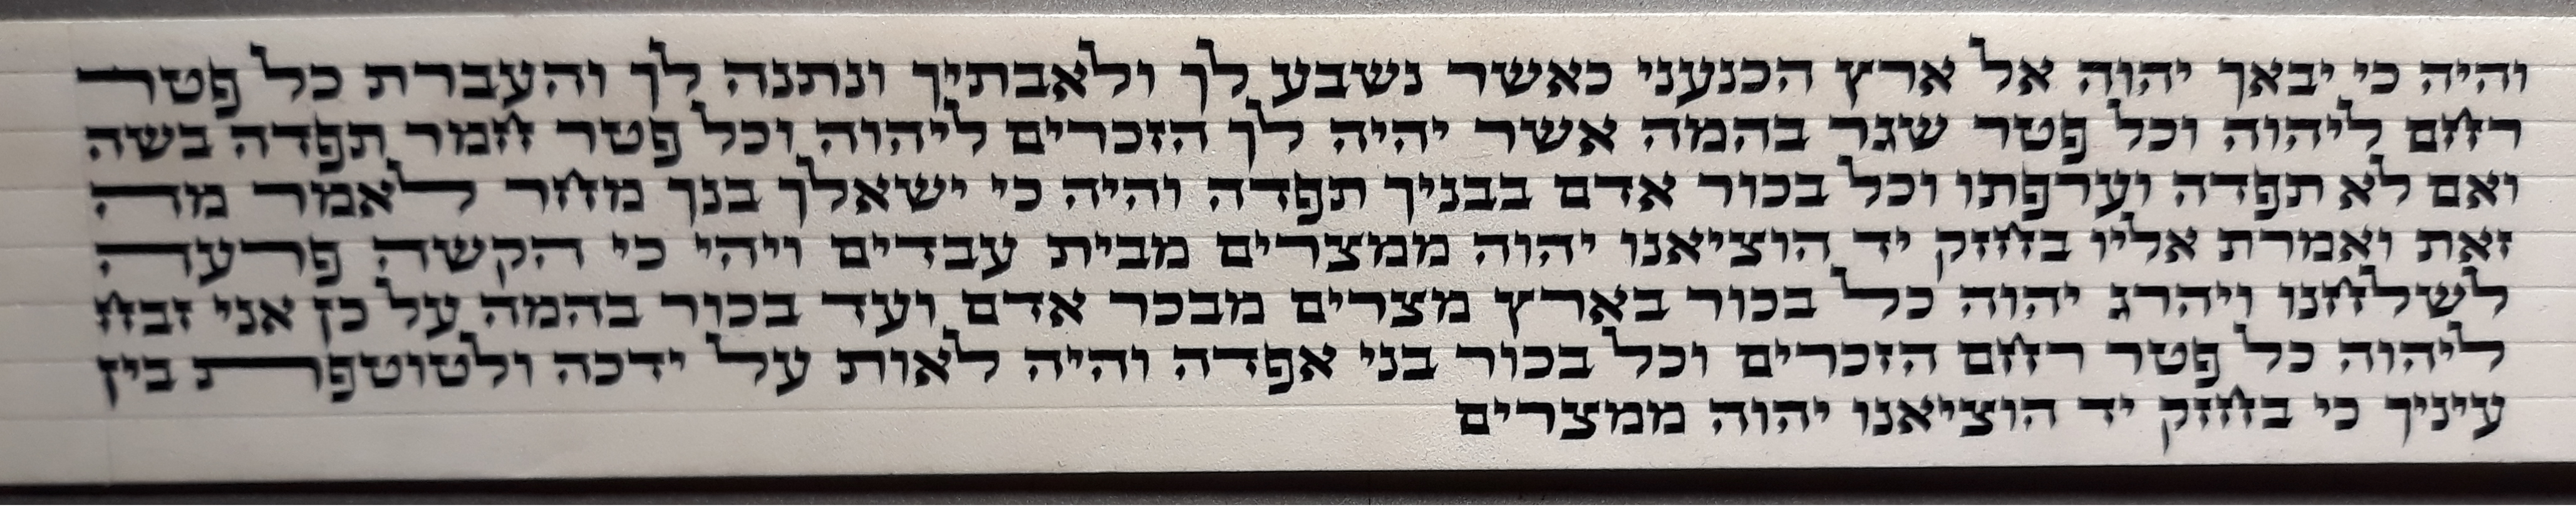

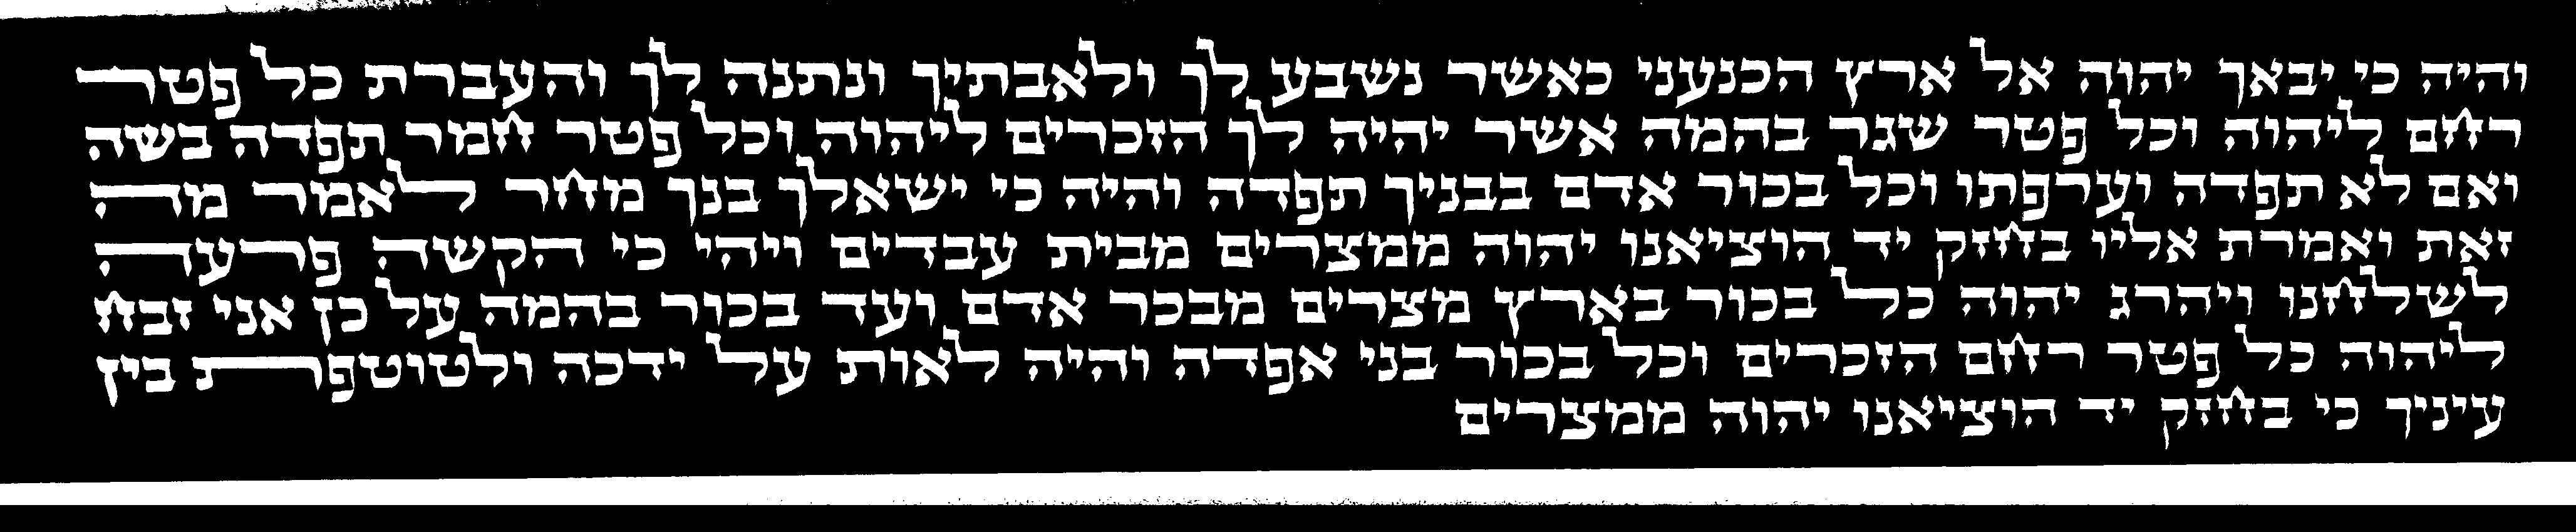

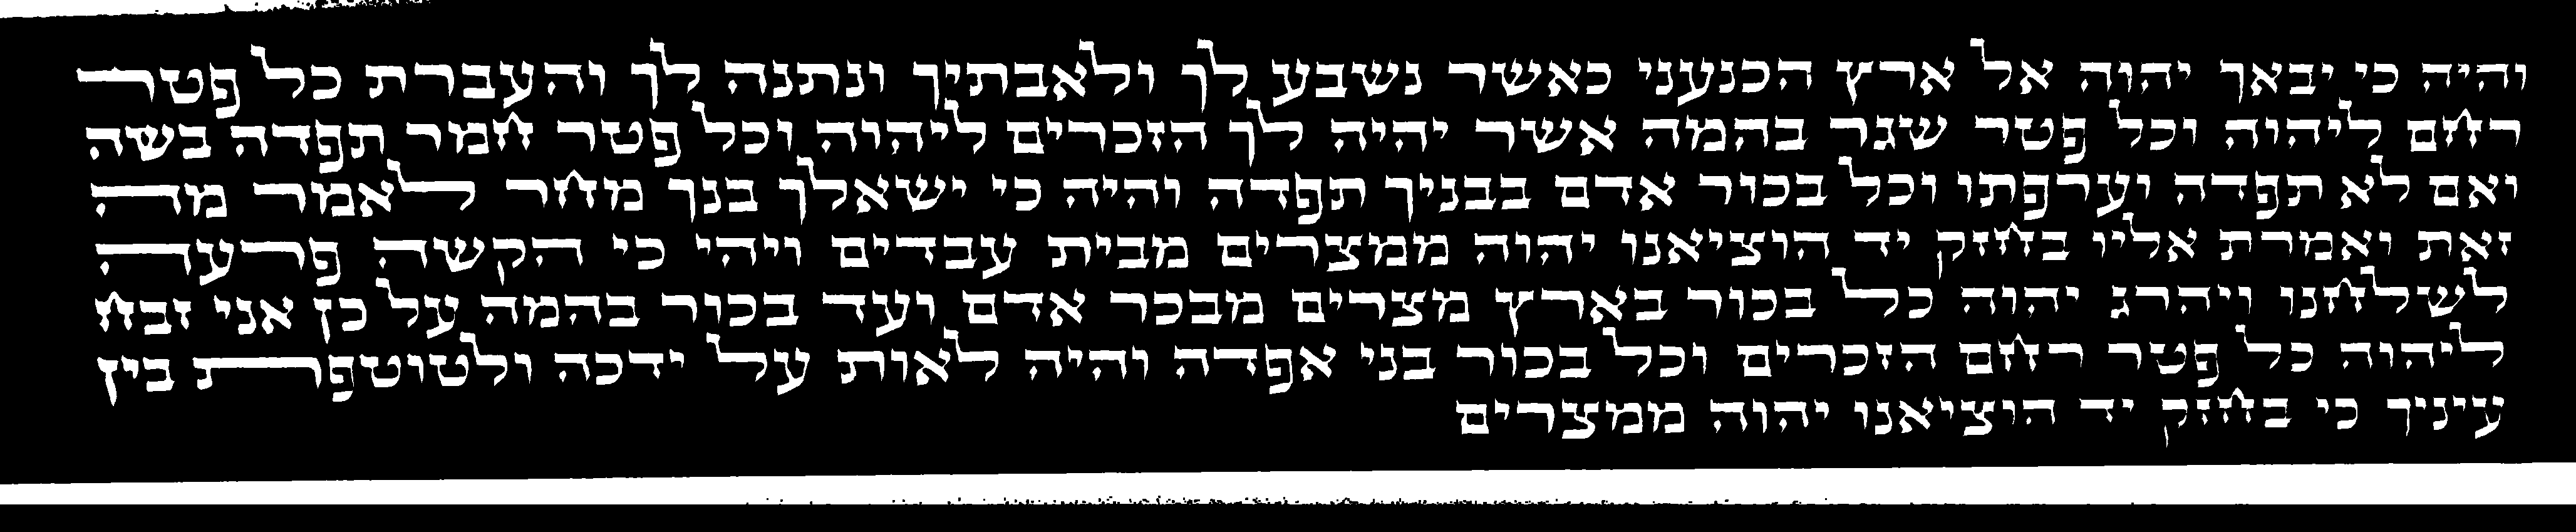

len:  486
width: 4113 - hight 67
the status: True
32
class:  zevel2
width: 12 - hight 21
the status: True
17
class:  noun_sofit
width: 12 - hight 23
the status: True
17
class:  noun_sofit
width: 43 - hight 18
the status: True
32
class:  zevel2
width: 13 - hight 21
the status: True
32
class:  zevel2
width: 10 - hight 18
the status: True
17
class:  noun_sofit
width: 40 - hight 41
the status: True
32
class:  zevel2
width: 56 - hight 42
the status: True
8
class:  he
width: 58 - hight 51
the status: True
13
class:  mem
width: 21 - hight 46
the status: True
27
class:  vav
width: 60 - hight 52
the status: True
6
class:  daleth
width: 51 - hight 39
the status: True
8
class:  he
width: 54 - hight 58
the status: True
24
class:  tsadik
width: 59 - hight 54
the status: True
13
class:  mem
width: 52 - hight 55
the status: True
14
class:  mem_sofit
width: 23 - hight 17
the status: True
29
class:  youd
width: 20 - hight 40
the status: True
15
class:  mixed
width: 27 - hight 57
the status: True
16
cla

ValueError: ignored

In [ ]:

ImageFolder = "/content/drive/My Drive/stam/all_letters"
ImageForPrediction = "/content/drive/My Drive/shmuel/images/1.png"
for img in show_rects(ImageForPrediction):
  # img = cv.imread(ImageForPrediction)
  img = cv.resize(img,(180,180))
  img = np.reshape(img,[1,180,180,3])

  predicted = reconstructed_model.predict(img)
  predicted_class = np.argmax(predicted)
  print(predicted_class)
  print("class: ", class_names[predicted_class])

# for folder in os.listdir(ImageFolder):
#     imageList = os.listdir(ImageFolder+"/"+folder)
#     imageDict [folder] = [ImageFolder+"/"+folder+"/"+I for I in imageList]
# print(imageDict["zain"][0])